In [1]:
import re
import os
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from scipy.optimize import curve_fit
from lmfit import Model
from lmfit.models import LinearModel

import sys
sys.path.append(os.path.join(Path(os.getcwd()).parents[0], "functions"))
import warnings
warnings.filterwarnings('ignore')
import helper_functions as hfn
import math

In [2]:
def func(x, a, b, c):
	return a * x**2 + b * x + c

In [3]:
model_lm = LinearModel()

In [4]:
path = Path(os.getcwd()).parents[0]

alldatapath = os.path.join(path, 'data')
datapath = os.path.join(alldatapath, 'clean')

likpath = os.path.join(path, 'data/likelihood_fit_bnds_from_allen_2022')

fracpath = os.path.join(path, 'input_fraction')
fracpath_csv = os.path.join(fracpath, 'csv')

figpath = os.path.join(path, 'figures')
hfn.dir_check(figpath)

fig6path = os.path.join(figpath, 'Fig6')
hfn.dir_check(fig6path)

fig6panelpaths = os.path.join(fig6path, 'panels')
hfn.dir_check(fig6panelpaths)

In [5]:
likpath

'/Users/rancze/Documents/GitHub/Tran_Van_Minh_et_al_2023/data/likelihood_fit_bnds_from_allen_2022'

# Load data

In [6]:
data  = pd.read_hdf(os.path.join(datapath, 'df_filt_ipsi.h5'))

In [7]:
datafrac = pd.read_csv(os.path.join(fracpath_csv, 'df_all_fraction.csv'))

In [8]:
areas = ['VISp','VISpm','VISl', 'VISam', 'VISal', 'RSPagl', 'RSPd', 'RSPv', 'AM', 'LD', 'LP', 'LGd', 'ORB', 'ACA', 'MOs', 'CLA', 'PTLp', 'TEa', 'AUD',]

In [9]:
data['rest'] = data['input'] - sum(data[area] for area in areas)

In [10]:
areas.append('rest')

# Load model data

In [11]:
summary_df_all = pd.DataFrame()
summary_df_ratio_all = pd.DataFrame()
params_dict = []

for file in os.listdir(likpath):
    if file.startswith('summary_df_ns'):
        
        index = re.findall('\d+',file)[0]
#         print(index)
        summary_df = pd.read_hdf(os.path.join(likpath, 'summary_df_ns_'+index+'.h5'))
        summary_df['file'] = index
        summary_df['input'] = sum(summary_df['inputs'+str(i)] for i in range(20))
        summary_df_all = pd.concat([summary_df_all, summary_df], axis = 0)#.reset_index(drop = True)
        
        summary_df_ratio = summary_df.iloc[:,1:21].copy()
        
        summary_df_ratio = summary_df_ratio.divide(summary_df['input'].values, axis = 0)
        summary_df_ratio['file'] = index
        summary_df_ratio['starters'] = summary_df['starters'] 
        
        summary_df_ratio_all = pd.concat([summary_df_ratio_all, summary_df_ratio], axis = 0)
        with open(os.path.join(likpath,'de_model_same_pbnds_'+index+'.pkl'), 'rb') as fp:
            params = pickle.load(fp)
        for i in range(int(len(params)/2)):
            params_dict.append({'file': index, 'Ni' : int(params[2*i]), 'p' : params[2*i + 1]})
params_df_all = pd.DataFrame(params_dict)

In [12]:
keys = ['inputs'+str(i) for i in range(20)]
dict_col = {}
for ind, i in enumerate(keys):
    dict_col[i] = areas[ind]

In [13]:
summary_df_all = summary_df_all.rename(columns = dict_col)

In [14]:
# to plot for examples 
thissummary_df = summary_df_all[summary_df_all.file == '76']
thisparams_df = params_df_all[params_df_all.file == '76']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


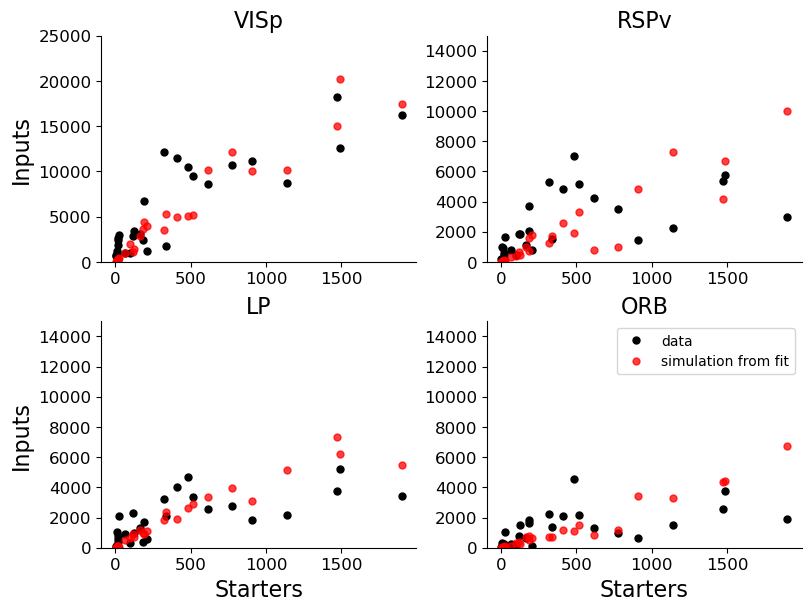

In [15]:
f1 = plt.figure(figsize = (16,4), constrained_layout = True)

gs = f1.add_gridspec(2,4)
ax = {}
areas_to_plot = ['VISp', 'RSPv', 'LP', 'ORB']

ax[0] = f1.add_subplot(gs[0:1, 0:2])
ax[0].set_ylabel('Inputs', fontsize = 16)
ax[0].plot(data.starter.values, data['VISp'].values, 'o', label = 'data', c='k', ms = 5)
ax[0].plot(thissummary_df.starters, thissummary_df['VISp'], 'o', alpha = 0.75, label = 'simulation from fit', c='r', ms= 5)
ax[0].set_ylim(0, 25000)

ax[1] = f1.add_subplot(gs[0:1, 2:4])
ax[1].plot(data.starter.values, data['RSPv'].values, 'o', label = 'data', c='k', ms = 5)
ax[1].plot(thissummary_df.starters, thissummary_df['RSPv'], 'o', alpha = 0.75, label = 'simulation from fit', c='r', ms= 5)
ax[1].set_ylim(0, 15000)

ax[2] = f1.add_subplot(gs[1:2, 0:2])
ax[2].set_ylabel('Inputs', fontsize = 16)
ax[2].plot(data.starter.values, data['LP'].values, 'o', label = 'data', c='k', ms = 5)
ax[2].plot(thissummary_df.starters, thissummary_df['LP'], 'o', alpha = 0.75, label = 'simulation from fit', c='r', ms= 5)
ax[2].set_ylim(0, 15000)
ax[2].set_xlabel('Starters', fontsize = 16)

ax[3] = f1.add_subplot(gs[1:2, 2:4])
# ax[0].set_ylabel('Inputs', fontsize = 16)
ax[3].plot(data.starter.values, data['ORB'].values, 'o', label = 'data', c='k', ms = 5)
ax[3].plot(thissummary_df.starters, thissummary_df['ORB'], 'o', alpha = 0.75, label = 'simulation from fit', c='r', ms= 5)
ax[3].set_ylim(0, 15000)
ax[3].set_xlabel('Starters', fontsize = 16)

plt.legend()
for i, area  in enumerate(areas_to_plot):
    ax[i].set_title(area, fontsize = 16)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
#     ax[i].set_rasterized(True)
    
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels() 
              + ax[1].get_xticklabels() + ax[1].get_yticklabels()
              + ax[2].get_xticklabels() + ax[2].get_yticklabels()
              + ax[3].get_xticklabels() + ax[3].get_yticklabels()):
    label.set_fontsize(12)
f1.set_size_inches(8, 6)
plt.savefig(os.path.join(fig6panelpaths, 'fig6a.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(fig6panelpaths, 'fig6a.eps'), bbox_inches = 'tight', format = 'eps', dpi = 500)

In [16]:
data_sub = data[areas].copy()
data_sub = data_sub.divide(data['input'].values, axis = 0)
data_sub['starters'] = data['starter']

In [17]:
summary_df_ratio_all_grouped = summary_df_ratio_all.groupby('starters').agg({'inputs'+str(i):['mean', 'std'] for i in range(20)})#({'inputs0': ['mean', 'std']})
summary_df_all_grouped = summary_df_all.groupby('starters').agg({area:['mean', 'std'] for area in areas})#({'inputs0': ['mean', 'std']})

In [18]:
summary_df_all_grouped['starters'] = summary_df_all_grouped.index
summary_df_ratio_all_grouped['starters'] = summary_df_ratio_all_grouped.index

In [19]:
this_df_an_p_all = []

for file in summary_df_ratio_all.file.unique():
    thisratio = summary_df_ratio_all[summary_df_ratio_all.file == file]
    for i, area in enumerate(areas):

        dfarea =thisratio[['starters', 'inputs'+str(i)]].dropna()#[thisdf.area == area].dropna()
        # fit polynomial
        thisx = dfarea.starters
        thisy = dfarea['inputs'+str(i)]
        popt, pcov = curve_fit(func, thisx, thisy)
        dfarea['fit'] = func(thisx, *popt)
        dfarealow = dfarea[dfarea.starters <= 125].dropna()
        dfareahigh = dfarea[dfarea.starters >=600].dropna()
        xlow = dfarealow.starters
        ylow = dfarealow['inputs'+str(i)]

        xhigh = dfareahigh.starters
        yhigh = dfareahigh['inputs'+str(i)]

        pars_low = model_lm.guess(ylow, x = xlow)
        results_low = model_lm.fit(ylow, pars_low, x = xlow)

        pars_high = model_lm.guess(yhigh, x = xhigh)
        results_high = model_lm.fit(yhigh, pars_high, x = xhigh)
        this_df_an_p_all.append({'file':file,'ind': i, 'area' : area, 'ratio_low' : dfarealow['inputs'+str(i)].mean(), 'ratio_high' : dfareahigh['inputs'+str(i)].mean(), 'ratio_fit_low' : dfarealow.fit.mean(), 'ratio_fit_high' : dfareahigh.fit.mean(), 'slope_low' : results_low.params['slope'].value, 'slope_high' : results_high.params['slope'].value})
an_df_p_all = pd.DataFrame(this_df_an_p_all)

In [20]:
this_df_an_p = []


for i, area in enumerate(areas):
    dfarea = summary_df_ratio_all_grouped[['starters', 'inputs'+str(i)]].dropna()#[thisdf.area == area].dropna()
    # fit polynomial
    thisx = dfarea.starters
    thisy = dfarea['inputs'+str(i)]['mean']
    popt, pcov = curve_fit(func, thisx, thisy)
    dfarea['fit'] = func(thisx, *popt)
    dfarealow = dfarea[dfarea.starters <= 125].dropna()
    dfareahigh = dfarea[dfarea.starters >=600].dropna()
    xlow = dfarealow.starters
    ylow = dfarealow['inputs'+str(i)]['mean']

    xhigh = dfareahigh.starters
    yhigh = dfareahigh['inputs'+str(i)]['mean']

    pars_low = model_lm.guess(ylow, x = xlow)
    results_low = model_lm.fit(ylow, pars_low, x = xlow)

    pars_high = model_lm.guess(yhigh, x = xhigh)
    results_high = model_lm.fit(yhigh, pars_high, x = xhigh)
    this_df_an_p.append({'ind': i, 'area' : area, 'ratio_low' : dfarealow['inputs'+str(i)]['mean'].mean(), 'ratio_high' : dfareahigh['inputs'+str(i)]['mean'].mean(), 'ratio_fit_low' : dfarealow.fit.mean(), 'ratio_fit_high' : dfareahigh.fit.mean(), 'slope_low' : results_low.params['slope'].value, 'slope_high' : results_high.params['slope'].value})
an_df_p = pd.DataFrame(this_df_an_p)

In [21]:
this_df_an = []


for i, area in enumerate(areas):
#     dfarea = summary_df_ratio[['starters', 'inputs'+str(i)]].dropna()#[thisdf.area == area].dropna()
    # fit polynomial
    thisx = data_sub.starters.values
    thisy = data_sub[area]
    popt, pcov = curve_fit(func, thisx, thisy)
    data_sub['fit'] = func(thisx, *popt)
    dfarealow = data_sub[data_sub.starters <= 125].dropna()
    dfareahigh = data_sub[data_sub.starters >= 600].dropna()
    xlow = dfarealow.starters.values
    ylow = dfarealow[area]

    xhigh = dfareahigh.starters.values
    yhigh = dfareahigh[area]

    pars_low = model_lm.guess(ylow, x = xlow)
    results_low = model_lm.fit(ylow, pars_low, x = xlow)

    pars_high = model_lm.guess(yhigh, x = xhigh)
    results_high = model_lm.fit(yhigh, pars_high, x = xhigh)
    this_df_an.append({'ind': i, 'area' : area, 'ratio_low' : dfarealow[area].mean(), 'ratio_high' : dfareahigh[area].mean(), 'ratio_fit_low' : dfarealow.fit.mean(), 'ratio_fit_high' : dfareahigh.fit.mean(), 'slope_low' : results_low.params['slope'].value, 'slope_high' : results_high.params['slope'].value})
an_df_data = pd.DataFrame(this_df_an)

In [22]:
an_df_p = an_df_p.reindex([8,9,10,11,12,13,14,15,16,17,18,0,1,2,3,4,5,6,7,19])
an_df_data = an_df_data.reindex([8,9,10,11,12,13,14,15,16,17,18,0,1,2,3,4,5,6,7,19])

In [23]:
an_df_p_all_reind = pd.DataFrame()
for file in an_df_p_all.file.unique():
    thisdf = an_df_p_all[an_df_p_all.file == file].reset_index(drop = True)
    thisdf = thisdf.reindex([8,9,10,11,12,13,14,15,16,17,18,0,1,2,3,4,5,6,7,19])
    an_df_p_all_reind = pd.concat([an_df_p_all_reind,thisdf], axis = 0)

In [24]:
an_df_p['type'] = 'model'
an_df_data['type']='data'

In [25]:
an_df = pd.concat([an_df_data, an_df_p], axis = 0)

In [26]:
an_df['fit_ratio'] = an_df['ratio_fit_high']/an_df['ratio_fit_low']

In [27]:
an_df['ratio'] = an_df['ratio_high']/an_df['ratio_low']

In [28]:
an_df_p_all_reind['fit_ratio'] = an_df_p_all_reind['ratio_fit_high']/an_df_p_all_reind['ratio_fit_low']

In [29]:
an_df_p_all_reind['ratio'] = an_df_p_all_reind['ratio_high']/an_df_p_all_reind['ratio_low']

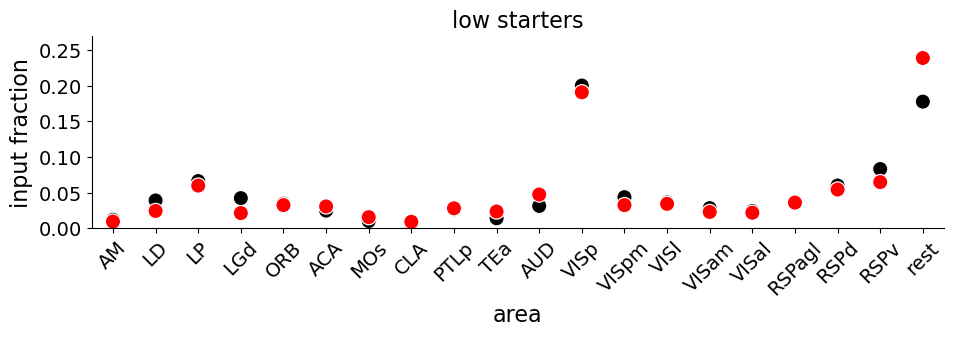

In [30]:
palette = ['k','r']
sns.scatterplot(data = an_df, hue = 'type', x = 'area', y = 'ratio_fit_low', legend = False, palette = palette, s = 120)
sns.pointplot(x='area', y="ratio_fit_low", data = an_df_p_all_reind, join=False,color= 'r')
figb1 = plt.gcf()
axb1 = plt.gca()
plt.xticks(rotation=45) 

plt.ylim(0, 0.27)
for label in (axb1.get_xticklabels() + axb1.get_yticklabels()):
    label.set_fontsize(14)
axb1.spines['right'].set_visible(False)
axb1.spines['top'].set_visible(False)
plt.ylabel('input fraction', fontsize = 16)
plt.xlabel('area', fontsize = 16)
plt.title('low starters', fontsize = 16)
figb1.set_size_inches(11, 2.5)
plt.savefig(os.path.join(fig6panelpaths, 'fig6b1.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(fig6panelpaths, 'fig6b1.eps'), bbox_inches = 'tight', format = 'eps', dpi = 500)

Text(0.5, 0, 'area')

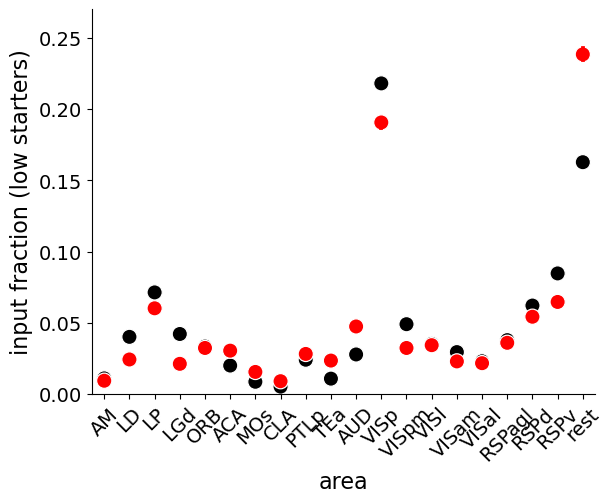

In [31]:
palette = ['k','r']
sns.scatterplot(data = an_df, hue = 'type', x = 'area', y = 'ratio_low', legend = False, palette = palette, s = 120)
sns.pointplot(x='area', y="ratio_low", data = an_df_p_all_reind, join=False,color= 'r')
figb1 = plt.gcf()
axb1 = plt.gca()
plt.xticks(rotation=45) 
figb1.set_size_inches(6.5, 5)
plt.ylim(0, 0.27)
for label in (axb1.get_xticklabels() + axb1.get_yticklabels()):
    label.set_fontsize(14)
axb1.spines['right'].set_visible(False)
axb1.spines['top'].set_visible(False)
plt.ylabel('input fraction (low starters)', fontsize = 16)
plt.xlabel('area', fontsize = 16)

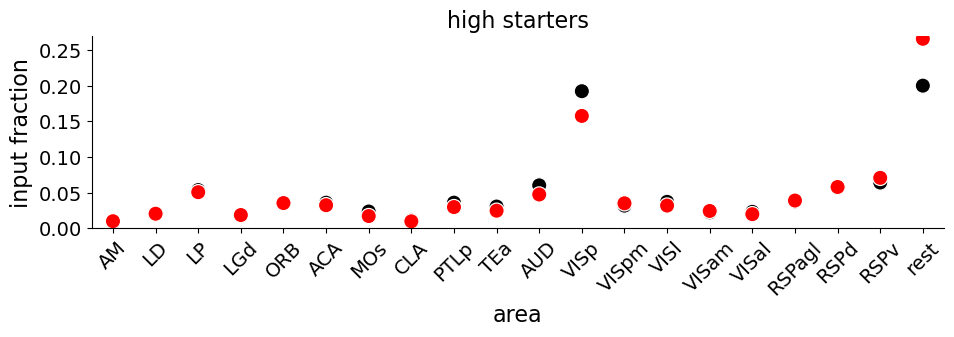

In [32]:
sns.scatterplot(data = an_df, hue = 'type', x = 'area', y = 'ratio_fit_high', legend = False, palette = palette, s = 120)
sns.pointplot(x='area', y="ratio_fit_high", data = an_df_p_all_reind, join=False,color= 'r')
figb2 = plt.gcf()
axb2 = plt.gca()
plt.xticks(rotation=45)

plt.ylim(0, 0.27)
for label in (axb2.get_xticklabels() + axb2.get_yticklabels()):
    label.set_fontsize(14)
axb2.spines['right'].set_visible(False)
axb2.spines['top'].set_visible(False)
plt.ylabel('input fraction', fontsize = 16)
plt.xlabel('area', fontsize = 16)
plt.title('high starters', fontsize = 16)
figb2.set_size_inches(11, 2.5)
plt.savefig(os.path.join(fig6panelpaths, 'fig6b2.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(fig6panelpaths, 'fig6b2.eps'), bbox_inches = 'tight', format = 'eps', dpi = 500)

Text(0.5, 0, 'area')

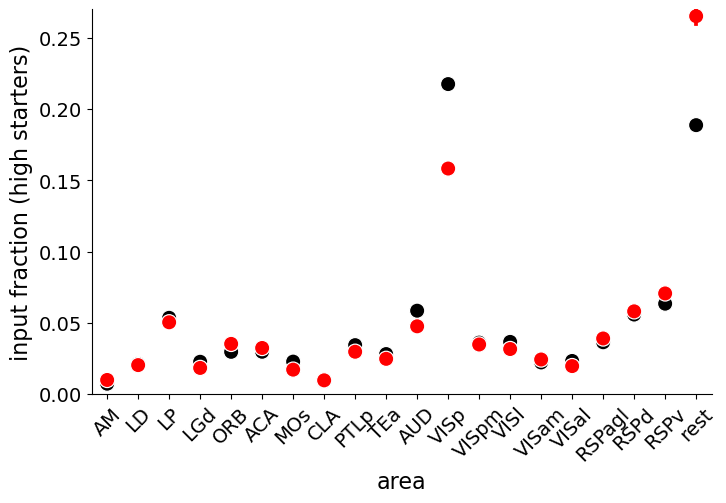

In [33]:
sns.scatterplot(data = an_df, hue = 'type', x = 'area', y = 'ratio_high', legend = False, palette = palette, s = 120)
sns.pointplot(x='area', y="ratio_high", data = an_df_p_all_reind, join=False,color= 'r')
figb2 = plt.gcf()
axb2 = plt.gca()
plt.xticks(rotation=45)
figb2.set_size_inches(8, 5)
plt.ylim(0, 0.27)
for label in (axb2.get_xticklabels() + axb2.get_yticklabels()):
    label.set_fontsize(14)
axb2.spines['right'].set_visible(False)
axb2.spines['top'].set_visible(False)
plt.ylabel('input fraction (high starters)', fontsize = 16)
plt.xlabel('area', fontsize = 16)


In [34]:
an_df_data_pre = an_df[an_df.type == 'data'].copy()

In [35]:
an_df_data_sorted = an_df[an_df.type == 'data'].copy()

In [36]:
an_df_data_sorted = an_df_data_sorted.sort_values(by='fit_ratio', ascending=False)#.head()

In [37]:
params_df_all['area'] = areas*int(params_df_all.shape[0]/len(areas))

In [38]:
params_df_all_new = pd.DataFrame()
for file in params_df_all.file.unique():
    theseparams = params_df_all[params_df_all.file == file]
    theseparams['rel_p'] = theseparams['p']/(theseparams['p'].mean())
    params_df_all_new = pd.concat([params_df_all_new, theseparams], axis = 0).reset_index(drop=True) 


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'VISp'),
  Text(1, 0, 'VISpm'),
  Text(2, 0, 'VISl'),
  Text(3, 0, 'VISam'),
  Text(4, 0, 'VISal'),
  Text(5, 0, 'RSPagl'),
  Text(6, 0, 'RSPd'),
  Text(7, 0, 'RSPv'),
  Text(8, 0, 'AM'),
  Text(9, 0, 'LD'),
  Text(10, 0, 'LP'),
  Text(11, 0, 'LGd'),
  Text(12, 0, 'ORB'),
  Text(13, 0, 'ACA'),
  Text(14, 0, 'MOs'),
  Text(15, 0, 'CLA'),
  Text(16, 0, 'PTLp'),
  Text(17, 0, 'TEa'),
  Text(18, 0, 'AUD'),
  Text(19, 0, 'rest')])

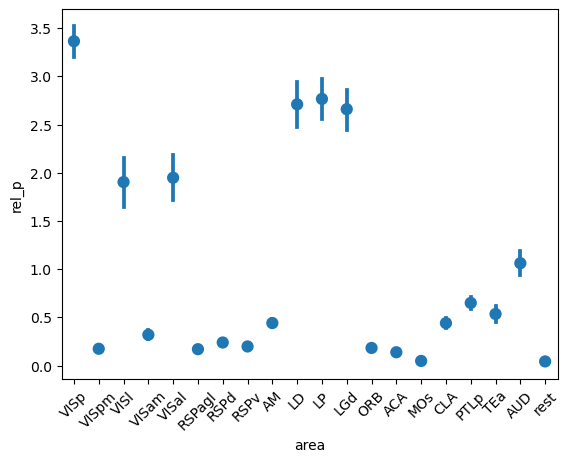

In [39]:
sns.pointplot(data = params_df_all_new, x = 'area', y = 'rel_p', join = False)
plt.xticks(rotation=45)

In [40]:
params_df_grouped = params_df_all.groupby('area').agg({'Ni':['mean', 'std'], 'p' : ['mean', 'std']})#({'inputs0': ['mean', 'std']})

In [41]:
params_df_grouped = params_df_grouped.sort_values([('p', 'mean')])

In [42]:
params_df_all_new_grouped = params_df_all_new.groupby('area').agg({'rel_p':['mean', 'std']})#({'inputs0': ['mean', 'std']})

In [43]:
params_df_all_new_grouped_sorted =params_df_all_new_grouped.sort_values([('rel_p', 'mean')], ascending = False)

In [44]:
an_df_data_toplot = an_df_data_sorted.copy()

In [45]:
an_df_data_toplot = an_df_data_toplot.set_index('area')

In [46]:
toplot = pd.concat([params_df_all_new_grouped_sorted, an_df_data_toplot[['fit_ratio','ratio']]],axis = 1)

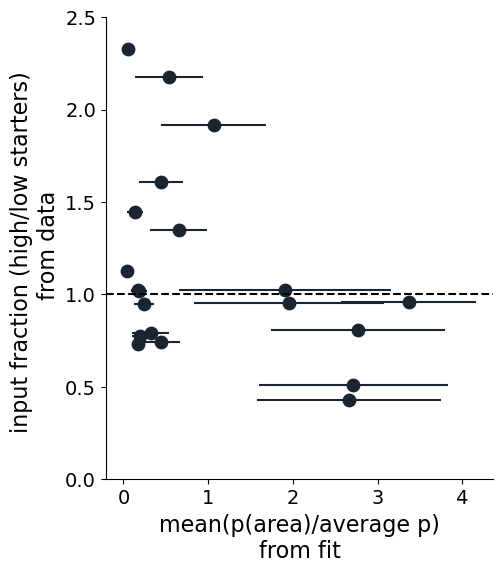

In [48]:
plt.scatter(toplot[('rel_p', 'mean')], toplot['fit_ratio'], c = 'xkcd:dark', s = 80)
plt.errorbar(toplot[('rel_p', 'mean')], toplot['fit_ratio'], xerr= toplot[('rel_p', 'std')], c = 'xkcd:dark', ls = 'None')

plt.axhline(1, ls = '--', c= 'k')
plt.ylim(0,2.5)


figc = plt.gcf()
axc = plt.gca()

for label in (axc.get_xticklabels() + axc.get_yticklabels()):
    label.set_fontsize(14)
axc.spines['right'].set_visible(False)
axc.spines['top'].set_visible(False)
plt.ylabel('input fraction (high/low starters) \n from data', fontsize = 16)
plt.xlabel('mean(p(area)/average p)\nfrom fit', fontsize = 16)

figc.set_size_inches(5, 6)
plt.savefig(os.path.join(fig6panelpaths, 'fig6c.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(fig6panelpaths, 'fig6c.eps'), bbox_inches = 'tight', format = 'eps', dpi = 500)

# format for latex

In [49]:
params_df_grouped = params_df_grouped.reindex(areas)

In [50]:
params_df_grouped[('Ni','mean')] = params_df_grouped[('Ni','mean')].apply("{:.2e}".format)

In [51]:
params_df_grouped[('Ni', 'std')] = params_df_grouped[('Ni','std')].apply("{:.2e}".format)

In [52]:
params_df_grouped[('p','mean')] = params_df_grouped[('p','mean')].apply("{:.2e}".format)

In [53]:
params_df_grouped[('p','std')] = params_df_grouped[('p','std')].apply("{:.2e}".format)

In [54]:
print(params_df_grouped.to_latex())

\begin{tabular}{lllll}
\toprule
{} & \multicolumn{2}{l}{Ni} & \multicolumn{2}{l}{p} \\
{} &      mean &       std &      mean &       std \\
area   &           &           &           &           \\
\midrule
VISp   &  3.63e+04 &  3.75e+04 &  5.83e-04 &  9.39e-05 \\
VISpm  &  1.01e+05 &  1.28e+04 &  2.99e-05 &  7.73e-06 \\
VISl   &  2.17e+04 &  2.37e+04 &  3.51e-04 &  2.41e-04 \\
VISam  &  4.80e+04 &  2.09e+04 &  5.46e-05 &  3.30e-05 \\
VISal  &  1.32e+04 &  1.56e+04 &  3.56e-04 &  2.13e-04 \\
RSPagl &  1.22e+05 &  3.09e+04 &  2.90e-05 &  1.13e-05 \\
RSPd   &  1.40e+05 &  5.32e+04 &  4.05e-05 &  1.66e-05 \\
RSPv   &  1.98e+05 &  6.24e+04 &  3.40e-05 &  1.57e-05 \\
AM     &  1.26e+04 &  3.27e+03 &  7.48e-05 &  2.91e-05 \\
LD     &  8.54e+03 &  1.20e+04 &  4.86e-04 &  2.02e-04 \\
LP     &  1.51e+04 &  1.30e+04 &  4.91e-04 &  1.81e-04 \\
LGd    &  6.07e+03 &  5.57e+03 &  4.72e-04 &  1.92e-04 \\
ORB    &  1.13e+05 &  4.44e+04 &  3.13e-05 &  1.37e-05 \\
ACA    &  1.50e+05 &  6.80e+04 &  2.37

In [55]:
params_df_grouped_float = params_df_grouped[params_df_grouped.index!= 'rest'].copy()
params_df_grouped_float = params_df_grouped_float.astype(np.float64)

In [56]:
params_df_grouped_float['area_groupes'] = ['VIS','VIS','VIS','VIS','VIS','RSP','RSP','RSP', 'Thal', 'Thal', 'Thal', 'Thal', 'Dist-ctx','Dist-ctx','Dist-ctx','Dist-ctx','Dist-ctx','Dist-ctx','Dist-ctx' ]

In [57]:
colors = ["blue", "dark cyan", "aquamarine", "lime"]#["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette = sns.xkcd_palette(colors)
sns.set_style("ticks")
hfont = {'fontname':'Myriad Pro'}